In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
import ptitprince as pt
import re #I import this library 'cause I need to deal with regular expressions
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer # para usar Yeo-Johnson
from scipy.stats import skew
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression


In [2]:
mergedDataBaseFile="Merged_DB.csv"
merged=pd.read_csv(mergedDataBaseFile)

In [3]:
merged['has_transitions'].dtype

dtype('bool')

In [4]:
merged.columns

Index(['id_band', 'score', 'has_transitions', 'albumCount', 'review_count'], dtype='object')

## Tabla de contenidos
1. [El Viaje Musical y su Impacto en la Reputacion](#El-Viaje-Musical-y-su-Impacto-en-la-Reputacion)
    1. [Punto de Partida: Una Base de Datos Unificada](#Punto-de-Partida:-Una-Base-de-Datos-Unificada)
    2. [Integracion de Datos Externos: La Voz del Publico](#Integracion-de-Datos-Externos:-La-Voz-del-Publico)
    3. [Transiciones de Genero: La Busqueda de la Autenticidad](#Transiciones-de-Genero:-La-Busqueda-de-la-Autenticidad)
2. [Data Wrangling adicional en la nueva db](#Data-Wrangling-adicional-en-la-nueva-db)
    1. [Deteccion y tratamiento de outliers](#Deteccion-y-tratamiento-de-outliers)
    2. [Observaciones preliminares de los dos escenarios (hay transiciones y no las hay)](#Observaciones-preliminares-de-los-dos-escenarios-(hay-transiciones-y-no-las-hay))
    3. [Tratamiento de los outliers por medio del Z score](#Tratamiento-de-los-outliers-por-medio-del-Z-score)
    4. [Tratamiento de outliers por IQR](#Tratamiento-de-outliers-por-IQR)
    5. [Variaciones en la media y mediana luego de la limpieza con Z Score e IQR](#Variaciones-en-la-media-y-mediana-luego-de-la-limpieza-con-Z-Score-e-IQR)
3. [One hot encoding para el feature "has transitions"](#One-hot-encoding-para-el-feature-"has-transitions")



# El Viaje Musical y su Impacto en la Reputación

En el vasto universo de la música, el cambio es constante. Las bandas evolucionan, adaptan sus estilos y experimentan con nuevos géneros. Pero, ¿qué impacto tiene realmente esta evolución en cómo perciben los fans a estas bandas?

## Punto de Partida: Una Base de Datos Unificada

Comenzamos con una base de datos unificada que consolida información sobre múltiples bandas y sus trayectorias musicales. Sin embargo, para obtener una visión más completa, necesitábamos algo más. Necesitábamos entender la opinión del público: esos aficionados apasionados que compran álbumes, asisten a conciertos y, en la era moderna, dejan sus opiniones en línea.

## Integración de Datos Externos: La Voz del Público

Para añadir esta dimensión crucial, nos sumergimos en el vasto océano de datos de Amazon. A través de un proceso de scraping, obtuvimos un tesoro: las reseñas de los discos de estas bandas. Estas reseñas, escritas por personas comunes que consumen su música, nos dieron el conteo de veces que cada disco fue reseñado, proporcionándonos un indicador del impacto y alcance de cada banda en el público.

Con esta nueva información en mano, pudimos calcular un "valor emergente" para cada banda: el valor promedio de las calificaciones de todos los discos de las bandas hasta la fecha respectiva. Esta métrica nos dio una idea más precisa del posicionamiento y reputación de una banda en un momento dado.

## Transiciones de Género: La Búsqueda de la Autenticidad

Con nuestro conjunto de datos enriquecido, nos aventuramos a responder una pregunta intrigante: ¿Qué sucede cuando una banda decide hacer una transición de género musical, en particular, moviéndose del death metal a otros géneros, o viceversa? O, ¿qué pasa cuando deciden mantenerse fieles a su género original?

Para visualizar y entender mejor estas dinámicas, recurrimos a los "raincloud plots" del score. Estos gráficos nos permitieron comparar las distribuciones de los scores entre las bandas que experimentaron con transiciones de género y aquellas que se mantuvieron firmes en su estilo original.




# Data Wrangling adicional en la nueva db
Con el objetivo de empezar a responder preguntas acerca del estudio de las puntuaciones críticas obtenidas por las bandas en función de los features 
"tiene transciones" (has_transitions) el cual da cuenta de si la banda cambio de género entre el death metal y otros géneros, "conteo de discos" (albumCount) y conteo de reseñas (review_count), procedo como primer paso a estudiar la forma de la distrubución de los datos primero en términos de la variable booleana

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


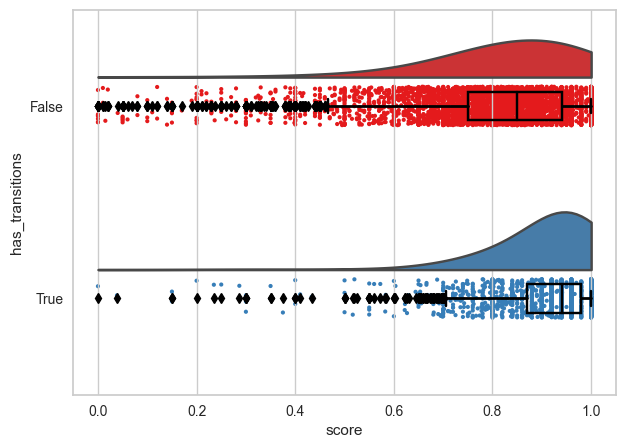

In [5]:
transitionsDF=merged[['has_transitions','score']]

f, ax=plt.subplots(figsize=(7,5))
dy="has_transitions"; dx="score"; ort="h";pal="Set1"

ax=pt.half_violinplot(x=dx,y=dy,data=transitionsDF,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data = transitionsDF, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = transitionsDF, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

ax.legend(loc='upper left')
plt.savefig('original_dist.png')
plt.show()

## Detección y tratamiento de outliers

Para hacer la detección y tratamiento de los datos atípicos o outliers en el proyecto se entra a considerar dos acercamientos: el primero consiste en calcular el z score de los datos del feature "score" con el fin de observar el efecto en las medidas de tendencia central de este feature dado el volumen de datos atípicos concentrado en la cola de la distribución hacia calificaciones bajas de los discos producidos por las bandas de metal, lo cual es llamativo sobre todo cuando estos se concentran muy cerca a calificaciones muy bajas. 

## Observaciones preliminares de los dos escenarios (hay transiciones y no las hay)

En el caso en el cual las bandas no han efectuado cambios de género, es decir han permanecido haciendo Death Metal de forma consistente se observa una media más alta en la calificación de los discos que en el caso en el cual la banda experimenta transiciones de género; sin embargo, la mediana es mucho mayor en el caso en este mismo escenario respecto al caso en el cual las bandas permanecen haciendo de forma consistente Death Metal; asimismo, se observan calificaciones más bajas de forma regular en las bandas que no se aventuran a hacer algo diferente al Death Metal que en las que si se arriesgan a experimentar con introducir o probar nuevos sonidos

In [6]:
TrueMean=transitionsDF.loc[transitionsDF['has_transitions']==True]['score'].mean()
TrueMedian=transitionsDF.loc[transitionsDF['has_transitions']==True]['score'].median()
FalseMean=transitionsDF.loc[transitionsDF['has_transitions']==False]['score'].mean()
FalseMedian=transitionsDF.loc[transitionsDF['has_transitions']==False]['score'].median()
print(f"la media de transiciones verdaderas es {TrueMean} y la mediana es {TrueMedian} y en el caso de las transciones en falso la media es {FalseMean} y la mediana es {FalseMedian}")

la media de transiciones verdaderas es 0.9041948579387051 y la mediana es 0.94 y en el caso de las transciones en falso la media es 0.824935069147989 y la mediana es 0.85


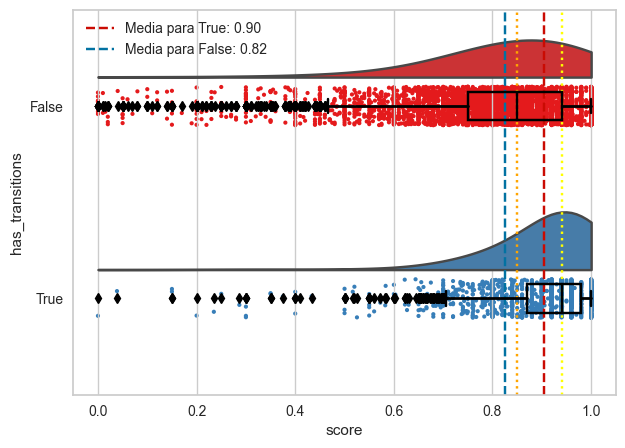

In [7]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=transitionsDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=transitionsDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=transitionsDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(TrueMean, color='r', linestyle='--', label=f'Media para True: {TrueMean:.2f}')
ax.axvline(FalseMean, color='b', linestyle='--', label=f'Media para False: {FalseMean:.2f}')

ax.axvline(TrueMedian, color='yellow', linestyle=':')
ax.axvline(FalseMedian, color='orange', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')

plt.show()


## Tratamiento de los outliers por medio del Z score

Una vez detectado que existen datos con calificaciones inusualmente bajas que pueden corresponder a resultados poco probables para la calificación media de los discos de una banda que tiene una trayectoria dada, se procede a imputar los datos usando la mediana ya que la distribución no es simétrica y tiene una cola hacia la izquierda y se elige usar una función para reemplazar esos valores atípicos por esta medida de tendencia central y posteriormente comparar con el filtrado de outliers por IQR

In [8]:
def zScoreFilter(df,col):
    df_copy = df.copy()
    zScore=(df_copy[col]-df_copy[col].mean())/df_copy[col].std()
    filtro=(zScore>3)|(zScore<-3)
    df_copy[col] = df_copy[col].where(~filtro, np.nan)
    median = df_copy[col].median()
    df_copy[col].fillna(median, inplace=True)
   
    return df_copy

In [9]:
mergedZScore=zScoreFilter(merged,'score')

In [10]:
zScoreDF=mergedZScore[['has_transitions','score']]
zScoreTrueMean=zScoreDF.loc[zScoreDF['has_transitions']==True]['score'].mean()
zScoreTrueMedian=zScoreDF.loc[zScoreDF['has_transitions']==True]['score'].median()
zScoreFalseMean=zScoreDF.loc[zScoreDF['has_transitions']==False]['score'].mean()
zScoreFalseMedian=zScoreDF.loc[zScoreDF['has_transitions']==False]['score'].median()
print(f"la media de transiciones verdaderas es {zScoreTrueMean} y la mediana es {zScoreTrueMedian} y en el caso de las transciones en falso la media es {zScoreFalseMean} y la mediana es {zScoreFalseMedian}")

la media de transiciones verdaderas es 0.909178179452639 y la mediana es 0.94 y en el caso de las transciones en falso la media es 0.8375390257789274 y la mediana es 0.86


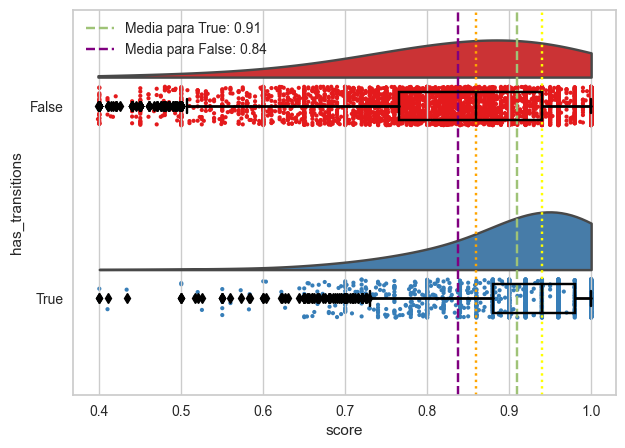

In [11]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=zScoreDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=zScoreDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=zScoreDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(zScoreTrueMean, color='g', linestyle='--', label=f'Media para True: {zScoreTrueMean:.2f}')
ax.axvline(zScoreFalseMean, color='purple', linestyle='--', label=f'Media para False: {zScoreFalseMean:.2f}')

ax.axvline(zScoreTrueMedian, color='yellow', linestyle=':')
ax.axvline(zScoreFalseMedian, color='orange', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')
plt.savefig('zscore.png')
plt.show()

## Tratamiento de outliers por IQR

In [12]:
def outliersFilter(df, col):
    df_copy = df.copy()
    
    Q1 = df_copy[col].quantile(0.25)
    Q3 = df_copy[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (df_copy[col] < (Q1 - 1.5 * IQR)) | (df_copy[col] > (Q3 + 1.5 * IQR))
    df_copy[col] = df_copy[col].where(~filtro, np.nan)
    median = df_copy[col].median()
    df_copy[col].fillna(median, inplace=True)
    
    return df_copy


In [13]:
mergedResult=outliersFilter(merged,'score')

In [14]:
noOutliersDF=mergedResult[['has_transitions','score']]
FilterTrueMean=noOutliersDF.loc[noOutliersDF['has_transitions']==True]['score'].mean()
FilterTrueMedian=noOutliersDF.loc[noOutliersDF['has_transitions']==True]['score'].median()
FilterFalseMean=noOutliersDF.loc[noOutliersDF['has_transitions']==False]['score'].mean()
FilterFalseMedian=noOutliersDF.loc[noOutliersDF['has_transitions']==False]['score'].median()
print(f"la media de transiciones verdaderas es {FilterTrueMean} y la mediana es {FilterTrueMedian} y en el caso de las transciones en falso la media es {FilterFalseMean} y la media es {FilterFalseMedian}")

la media de transiciones verdaderas es 0.9112410586583752 y la mediana es 0.94 y en el caso de las transciones en falso la media es 0.8487282209093834 y la media es 0.87


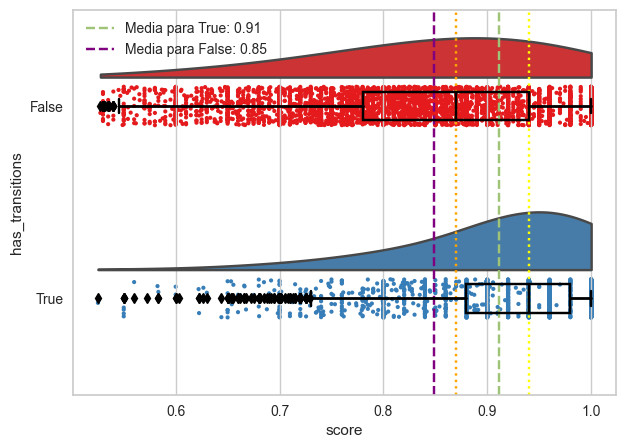

In [15]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=noOutliersDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=noOutliersDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=noOutliersDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(FilterTrueMean, color='g', linestyle='--', label=f'Media para True: {FilterTrueMean:.2f}')
ax.axvline(FilterFalseMean, color='purple', linestyle='--', label=f'Media para False: {FilterFalseMean:.2f}')

ax.axvline(FilterTrueMedian, color='yellow', linestyle=':')
ax.axvline(FilterFalseMedian, color='orange', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')
plt.savefig('IQR.png')
plt.show()

## Variaciones en la media y mediana luego de la limpieza con Z Score e IQR

In [16]:
varIQRMean=round((abs(FilterTrueMean-TrueMean)/TrueMean)*100,1)
varIQRMedian=round((abs(FilterTrueMedian-TrueMedian)/TrueMedian)*100,1)
varZSCOREMean=round((abs(zScoreTrueMean-TrueMean)/TrueMean)*100,1)
varZSCOREMedian=round((abs(zScoreTrueMedian-TrueMedian)/TrueMedian)*100,1)
varIQRMeanF=round((abs(FilterFalseMean-FalseMean)/FalseMean)*100,1)
varIQRMedianF=round((abs(FilterFalseMedian-FalseMedian)/FalseMedian)*100,1)
varZSCOREMeanF=round((abs(zScoreFalseMean-FalseMean)/FalseMean)*100,1)
varZSCOREMedianF=round((abs(zScoreFalseMedian-FalseMedian)/FalseMedian)*100,1)
f"Las variaciones porcentuales de la media y mediana para el caso de los valores True, son, respectivamente usando filtrado por IQR son de {varIQRMean}% y {varIQRMedian}%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de {varZSCOREMean}% y {varZSCOREMedian}% y para el caso de False, son, respectivamente usando filtrado por IQR son de {varIQRMeanF}% y {varIQRMedianF}%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de {varZSCOREMeanF}% y {varZSCOREMedianF}%"



'Las variaciones porcentuales de la media y mediana para el caso de los valores True, son, respectivamente usando filtrado por IQR son de 0.8% y 0.0%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de 0.6% y 0.0% y para el caso de False, son, respectivamente usando filtrado por IQR son de 2.9% y 2.4%. Por otro lado, las variaciones porcentuales de la media y mediana son, respectivamente usando filtrado por ZScore son de 1.5% y 1.2%'

# One hot encoding para el feature "has transitions" 
Con el objetivo de hacer un one hot encoding con la columna del booleano "has transitions" y aprovechando su caracter booleano solo cambio el tipo de dato a entero, de manera que los True se vuelven 1

In [17]:
mlDB=merged.copy()

In [18]:
mlDB['has_transitions']=mlDB['has_transitions'].astype(int)

In [19]:
mlDB

,id_band,score,has_transitions,albumCount,review_count
0,11143,0.500000,1,1.0,1
1,14768,0.770000,1,1.0,1
2,16693,0.860000,1,2.0,1
3,16950,0.783333,1,1.0,1
4,20572,0.550000,1,3.0,1
...,...,...,...,...,...
8090,51016,0.700000,1,1.0,4
8091,56642,0.700000,1,1.0,4
8092,60904,0.680000,0,1.0,6
8093,40786,0.680000,0,1.0,6


In [20]:
merged['albumCount'].max()

17.0

# Tratamiento de outliers usando la transformación de Yeo-Johnson

Debido a que la distribución de datos observada para los datos asociados al score de las bandas presenta un evidente sesgo hacia la izquierda, el proceder a normalizar los datos con un standar scaler o robust scaler puede llevar a interpretar erroneamente datos como outliers, por lo que se procede a usar la transformación de Yeo-Johnson para verificar los datos atipicos y luego comparar los resultados obtenidos con los analizados por IQR.

La transformación de Yeo-Johns es una variación de la transformación de Box-Cox que puede ser apliacada a datos que son por defecto negativos y muy cercanos a cero. La transformación de Box-Cox está definida como:



$$ 
\phi(y,\lambda) = 
     \begin{cases}
       \text{si $\lambda \neq 0$,} &\frac{y^{\lambda}-1}{\lambda}\\
       \text{si $\lambda = 0$,} &\ln (y) \\
     \end{cases}
$$

Ahora bien, como la distribución de los datos de los scores de las bandas exhiben un sesgo hacia la izquierda y se dan observaciones de este cercanas a cero se escoge trabajar con la transformación Yeo-Johns que está dada por:


$$ 
\psi(y,\lambda) = 
     \begin{cases} 
\frac{(y + 1)^\lambda - 1}{\lambda} & \text{si } \lambda \neq 0 \text{ y } y \geq 0 \\
\frac{-(-y + 1)^\lambda + 1}{\lambda} & \text{si } \lambda \neq 0 \text{ y } y < 0 \\
\log(y + 1) & \text{si } \lambda = 0 \text{ y } y \geq 0 \\
-\log(-y + 1) & \text{si } \lambda = 0 \text{ y } y < 0 
\end{cases}
$$

En este contexto, $\lambda$ corresponde a un párametro que define la forma de la transformación aplicada a los datos. Si $\lambda=0$ tendríamos una transformación logaritmica que sirve para amplificar los datos en rangos pequeños, pues la función logaritmo es sensible a las variaciones relativas (más sensible que un $x^{2}$ esto permite observar amplificadas las diferencias de los datos que pueden ser considerados outliers. Si $\lambda=1$, tenemos una transformación identidad que no altera los datos y finalmente si $\lambda<0$, tenemos que determinar los valores de este parámetro por el metódo de máxima verosimilitud. Por fortuna, el metódo PowerTransformer de Sklearn cálcula y ajusta dichos $\lambda$. En este caso y debido al sesgo a la izquierda se aplica Yeo-Johns para dteerminar si nuestros aparentes outliers lo son o no y como se pueden explicar.  



In [21]:
mergedYeo=merged.copy()

# Aplicación de la transformación de Yeo-Johns

In [22]:
data = mergedYeo['score'].values.reshape(-1, 1)
powerT = PowerTransformer(method='yeo-johnson')
mergedYeo[['score_yj']] = powerT.fit_transform(mergedYeo[['score']])


In [23]:
yeoDF=mergedYeo.copy()

# Revisión superficial de la normalidad de la distribución transformada

In [24]:
# Calcular la media
mean = np.mean(mergedYeo['score_yj'])

# Calcular la mediana
median = np.median(mergedYeo['score_yj'])

# Calcular la varianza
variance = np.var(mergedYeo['score_yj'])

# Calcular la asimetría
data_skew = skew(mergedYeo['score_yj'])

# Imprimir los resultados
print("Media:", mean)
print("Mediana:", median)
print("Varianza:", variance)
print("Asimetría:", data_skew)

Media: 0.0
Mediana: 0.0771036148614697
Varianza: 1.0000000000000002
Asimetría: -0.21149136633803056


# RaincloudPlot de la distribución transformada con Yeo-Johns

Se procede a estudiar la forma de la distribución transformada para posteriormente estudiar la naturaleza de los datos clásificados como atípicos en la distribución sin transformar

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


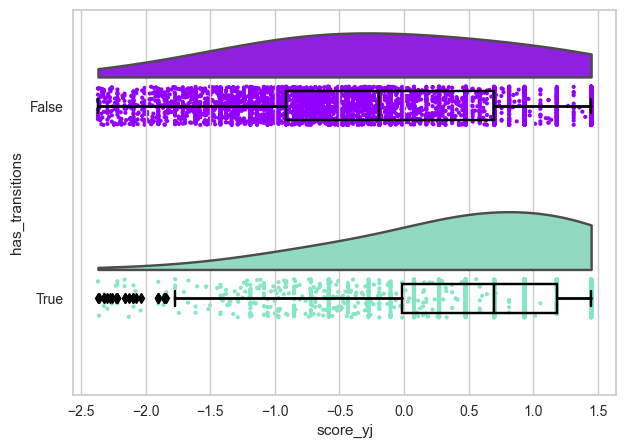

In [25]:
transitionsYeo=yeoDF[['has_transitions','score_yj']]

f, ax=plt.subplots(figsize=(7,5))
dy="has_transitions"; dx="score_yj"; ort="h";pal = ["#9400FF", "#85E6C5"]


ax=pt.half_violinplot(x=dx,y=dy,data=yeoDF,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data = yeoDF, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = yeoDF, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

ax.legend(loc='upper left')
#plt.savefig('original_dist.png')
plt.show()

# Marcado de datos atípicos en la distribución transformada

En esta sección se modifica y adapta la función para detección de datos atípicos con el objetivo de comparar dicha clasificación sobre la distribución original y la transformada

In [26]:
def outliersMarker(df, col1, col2):
    df_copy = df.copy()
    
    # Procesamiento para col1
    Q1_col1 = df_copy[col1].quantile(0.25)
    Q3_col1 = df_copy[col1].quantile(0.75)
    IQR_col1 = Q3_col1 - Q1_col1
    filtro_col1 = (df_copy[col1] < (Q1_col1 - 1.5 * IQR_col1)) | (df_copy[col1] > (Q3_col1 + 1.5 * IQR_col1))
    df_copy[col1] = df_copy[col1].where(~filtro_col1, np.nan)
    
    # Procesamiento para col2
    Q1_col2 = df_copy[col2].quantile(0.25)
    Q3_col2 = df_copy[col2].quantile(0.75)
    IQR_col2 = Q3_col2 - Q1_col2
    filtro_col2 = (df_copy[col2] < (Q1_col2 - 1.5 * IQR_col2)) | (df_copy[col2] > (Q3_col2 + 1.5 * IQR_col2))
    df_copy[col2] = df_copy[col2].where(~filtro_col2, np.nan)
    
    return df_copy


In [27]:
yeoOutliers=outliersMarker(yeoDF,'score','score_yj')

In [28]:
yeoOutliers

,id_band,score,has_transitions,albumCount,review_count,score_yj
0,11143,NaN,True,1.0,1,-1.902681
1,14768,0.770000,True,1.0,1,-0.787386
2,16693,0.860000,True,2.0,1,-0.104543
3,16950,0.783333,True,1.0,1,-0.698906
4,20572,0.550000,True,3.0,1,-1.772381
...,...,...,...,...,...,...
8090,51016,0.700000,True,1.0,4,-1.189858
8091,56642,0.700000,True,1.0,4,-1.189858
8092,60904,0.680000,False,1.0,6,-1.287557
8093,40786,0.680000,False,1.0,6,-1.287557


In [29]:
yeoOutliers[yeoOutliers['score_yj'].isna()]

,id_band,score,has_transitions,albumCount,review_count,score_yj


# Discriminación de datos atípicos a partir de la comparación directa entre los datos originales y los transformados

Es esta sección se procede a comparar los resultados de la clasificación de los datos atípicos de la base de datos actualizada con los de la base de datops actualizada y transformada, duiscriminando según el valor del Booleano "has_transitions"

In [30]:
filtered_rows_true = yeoOutliers[(yeoOutliers['has_transitions'] == True) & (yeoOutliers['score'].isna())]


In [31]:
filtered_rows_true

,id_band,score,has_transitions,albumCount,review_count,score_yj
0,11143,NaN,True,1.0,1,-1.902681
26,35746,NaN,True,3.0,1,-2.231756
67,37115,NaN,True,1.0,1,-2.219113
73,37148,NaN,True,2.0,1,-2.131401
88,37195,NaN,True,1.0,1,-2.323092
93,37207,NaN,True,3.0,1,-2.039659
108,37272,NaN,True,1.0,1,-2.323092
111,37277,NaN,True,1.0,1,-2.370062
132,37395,NaN,True,1.0,1,-2.296699
147,37469,NaN,True,1.0,1,-2.164032


In [32]:
filtered_rows_false = yeoOutliers[(yeoOutliers['has_transitions'] == False) & (yeoOutliers['score'].isna())]

In [33]:
filtered_rows_false

,id_band,score,has_transitions,albumCount,review_count,score_yj
326,212,NaN,False,1.0,1,-2.358624
327,213,NaN,False,1.0,1,-2.219113
333,259,NaN,False,1.0,1,-2.358624
355,510,NaN,False,1.0,1,-2.296699
369,728,NaN,False,1.0,1,-1.902681
...,...,...,...,...,...,...
4289,36845,NaN,False,3.0,1,-2.097483
4291,36856,NaN,False,1.0,1,-1.902681
4302,36973,NaN,False,1.0,1,-2.219113
4313,37065,NaN,False,1.0,1,-2.157796


In [34]:
filtered_rows_false['score'].isna().sum()

291

In [35]:
filtered_rows_false['score_yj'].isna().sum()

0

# Conclusiones del filtrado

Tras aplicar la transformación de Yeo-Johns, se evidencia que los datos previamente identificados como atípicos en la distribución original mediante IQR, no son considerados así en la transformada. Esto es coherente, ya que ciertos discos de bandas pueden recibir reseñas negativas de la crítica. Incluso, es posible que reciban calificaciones bajas de manera consecutiva. 

# Obtención de Insights

En esta sección se realiza un EDA adicional con los datos obtenidos al obtener nuevos datos para la base nueva con el objetivo de plantear un algoritmo de regresión y estudiar los coeficientes de correlación para las regresiones que se plantean en términos de los features 'promedio discos lanzados' 'Transiciones' y 'promedio de reviews recibidas'

In [36]:
scatterMergedYeo=mergedYeo[['albumCount','has_transitions','score']]

In [37]:
scatterMergedYeo

,albumCount,has_transitions,score
0,1.0,True,0.500000
1,1.0,True,0.770000
2,2.0,True,0.860000
3,1.0,True,0.783333
4,3.0,True,0.550000
...,...,...,...
8090,1.0,True,0.700000
8091,1.0,True,0.700000
8092,1.0,False,0.680000
8093,1.0,False,0.680000


In [38]:
scatterMergedYeo['has_transitions']=scatterMergedYeo['has_transitions'].astype(int)
scatterMergedYeo

,albumCount,has_transitions,score
0,1.0,1,0.500000
1,1.0,1,0.770000
2,2.0,1,0.860000
3,1.0,1,0.783333
4,3.0,1,0.550000
...,...,...,...
8090,1.0,1,0.700000
8091,1.0,1,0.700000
8092,1.0,0,0.680000
8093,1.0,0,0.680000


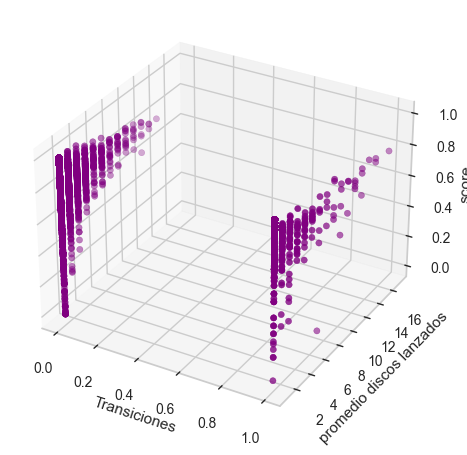

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(scatterMergedYeo['has_transitions'], scatterMergedYeo['albumCount'], scatterMergedYeo['score'], c='purple', marker='o')

# Añadir etiquetas
ax.set_xlabel('Transiciones')
ax.set_ylabel('promedio discos lanzados')
ax.set_zlabel('score')

# Mostrar el gráfico
plt.show()

In [40]:
scatterMergedYeo2=mergedYeo[['review_count','has_transitions','score']]

In [41]:
scatterMergedYeo2['has_transitions']=scatterMergedYeo2['has_transitions'].astype(int)
scatterMergedYeo2

,review_count,has_transitions,score
0,1,1,0.500000
1,1,1,0.770000
2,1,1,0.860000
3,1,1,0.783333
4,1,1,0.550000
...,...,...,...
8090,4,1,0.700000
8091,4,1,0.700000
8092,6,0,0.680000
8093,6,0,0.680000


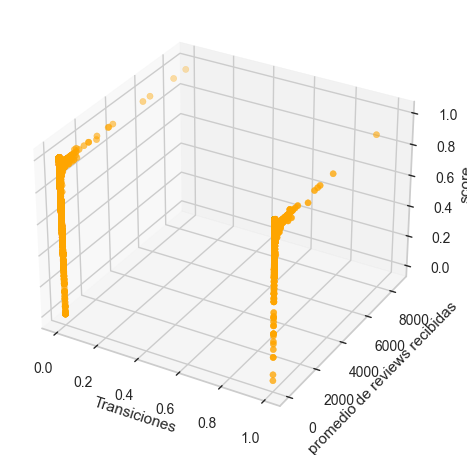

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(scatterMergedYeo2['has_transitions'], scatterMergedYeo2['review_count'], scatterMergedYeo2['score'], c='orange', marker='o')

# Añadir etiquetas
ax.set_xlabel('Transiciones')
ax.set_ylabel('promedio de reviews recibidas')
ax.set_zlabel('score')

# Mostrar el gráfico
plt.show()

In [43]:
XD_with = scatterMergedYeo[scatterMergedYeo['has_transitions'] == 1][['albumCount']]
yD_with = scatterMergedYeo[scatterMergedYeo['has_transitions'] == 1]['score']

XD_without = scatterMergedYeo[scatterMergedYeo['has_transitions'] == 0][['albumCount']]
yD_without = scatterMergedYeo[scatterMergedYeo['has_transitions'] == 0]['score']

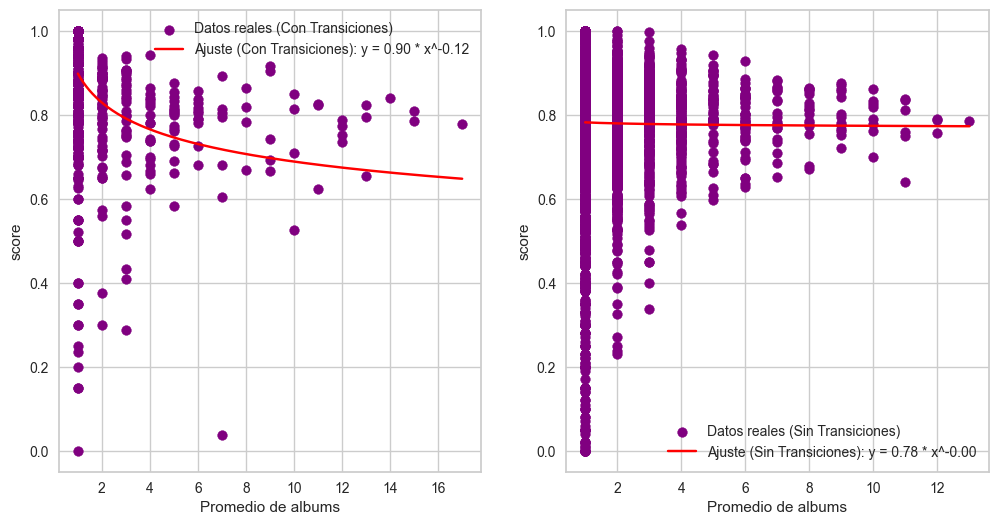

In [44]:
def fit_and_plot2(XD_filtered, yD_filtered, label, subplot_index):
    plt.subplot(subplot_index)
    
    if np.any(yD_filtered <= 0):
        print("Warning: yD_filtered contiene valores no positivos, aplicando corrección.")
        yD_filtered += 1e-9  # 1e-9 es un pequeño valor para evitar tomar log(0)
    
    X_log = np.log(XD_filtered['albumCount']).values.reshape(-1, 1)
    y_log = np.log(yD_filtered)

    
    X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_log, y_log)

    a = np.exp(model.intercept_)
    b = model.coef_[0]

    x_range = np.linspace(min(XD_filtered['albumCount']), max(XD_filtered['albumCount']), 400)
    x_range_log = np.log(x_range)

    y_pred_log = model.predict(x_range_log.reshape(-1, 1))
    y_pred = np.exp(y_pred_log)

    plt.scatter(XD_filtered['albumCount'], yD_filtered, label=f'Datos reales ({label})',color='purple')
    plt.plot(x_range, y_pred, label=f'Ajuste ({label}): y = {a:.2f} * x^{b:.2f}',color='red')

    plt.xlabel('Promedio de albums')
    plt.ylabel('score')
    plt.legend()

# Preparar el canvas para las dos subgráficas
plt.figure(figsize=(12, 6))

# Graficar la primera subgráfica para datos con transiciones
fit_and_plot2(XD_with, yD_with, 'Con Transiciones', 121)

# Graficar la segunda subgráfica para datos sin transiciones
fit_and_plot2(XD_without, yD_without, 'Sin Transiciones', 122)

# Mostrar ambas subgráficas
plt.show()


In [45]:
XD_with2 = scatterMergedYeo2[scatterMergedYeo2['has_transitions'] == 1][['review_count']]
yD_with2 = scatterMergedYeo2[scatterMergedYeo2['has_transitions'] == 1]['score']

XD_without2 = scatterMergedYeo2[scatterMergedYeo2['has_transitions'] == 0][['review_count']]
yD_without2 = scatterMergedYeo2[scatterMergedYeo2['has_transitions'] == 0]['score']

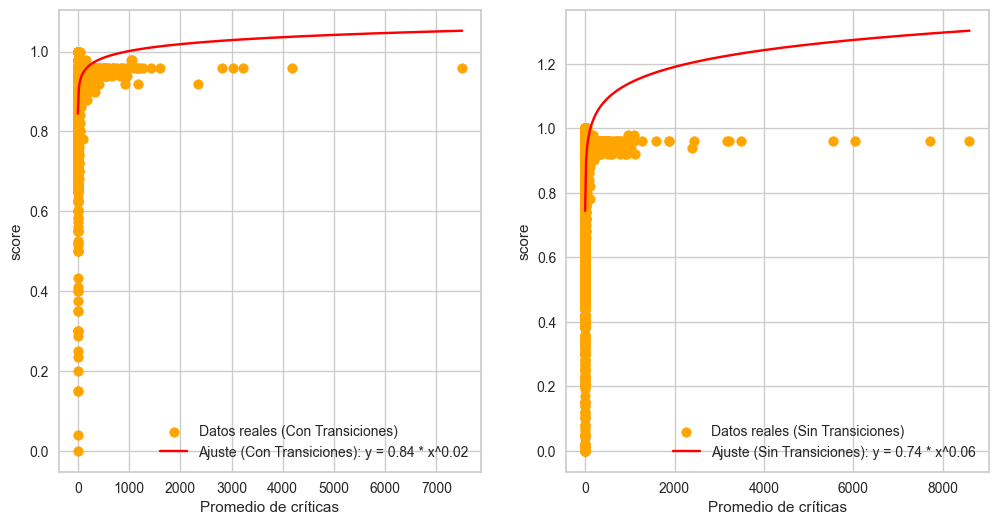

In [46]:
def fit_and_plot2(XD_filtered, yD_filtered, label, subplot_index):
    plt.subplot(subplot_index)
    
    if np.any(yD_filtered <= 0):
        print("Warning: yD_filtered contiene valores no positivos, aplicando corrección.")
        yD_filtered += 1e-9  # 1e-9 es un pequeño valor para evitar tomar log(0)
    
    X_log = np.log(XD_filtered['review_count']).values.reshape(-1, 1)
    y_log = np.log(yD_filtered)

    
    X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_log, y_log)

    a = np.exp(model.intercept_)
    b = model.coef_[0]

    x_range = np.linspace(min(XD_filtered['review_count']), max(XD_filtered['review_count']), 400)
    x_range_log = np.log(x_range)

    y_pred_log = model.predict(x_range_log.reshape(-1, 1))
    y_pred = np.exp(y_pred_log)

    plt.scatter(XD_filtered['review_count'], yD_filtered, label=f'Datos reales ({label})',color='orange')
    plt.plot(x_range, y_pred, label=f'Ajuste ({label}): y = {a:.2f} * x^{b:.2f}',color='red')

    plt.xlabel('Promedio de críticas')
    plt.ylabel('score')
    plt.legend()

# Preparar el canvas para las dos subgráficas
plt.figure(figsize=(12, 6))

# Graficar la primera subgráfica para datos con transiciones
fit_and_plot2(XD_with2, yD_with2, 'Con Transiciones', 121)

# Graficar la segunda subgráfica para datos sin transiciones
fit_and_plot2(XD_without2, yD_without2, 'Sin Transiciones', 122)

# Mostrar ambas subgráficas
plt.show()

# TRATAMIENTO DE LOS DATOS MEDIANTE REGRESIÓN A UNA LEY DE POTENCIAS

En esta sección se busca verificar que la hipotesis de un posible ajuste de los datos a una tendencia tipo ley de potencias, sea valida, es decir:

$$s(p_{alb})=\alpha_{1}*p^{\beta_{1}}_{alb}$$ y

$$s(p_{rev})=\alpha_{2}*p^{\beta_{2}}_{rev}$$

Siendo $s$ el score y $ p_{alb} $, $ p_{rev} $ los valores del promedio de albums y reviews respectivamente. Para efectuar el ajuste se procede de manera tradicional, tomando los logaritmos de las variables dependientes e independientes para luego ajustarlas de forma lineal.

In [47]:
logYeo2=scatterMergedYeo2.copy()

In [48]:
logYeo2['log_score'] = logYeo2['score'].apply(lambda x: np.log(x))
logYeo2['log_review_count'] = logYeo2['review_count'].apply(lambda x: np.log(x))


In [49]:
logYeo2

,review_count,has_transitions,score,log_score,log_review_count
0,1,1,0.500000,-0.693147,0.000000
1,1,1,0.770000,-0.261365,0.000000
2,1,1,0.860000,-0.150823,0.000000
3,1,1,0.783333,-0.244197,0.000000
4,1,1,0.550000,-0.597837,0.000000
...,...,...,...,...,...
8090,4,1,0.700000,-0.356675,1.386294
8091,4,1,0.700000,-0.356675,1.386294
8092,6,0,0.680000,-0.385662,1.791759
8093,6,0,0.680000,-0.385662,1.791759


# Plot del logaritmo natural del score en funcióm del logaritmo natural del número de reviews y el booleano de transiciones

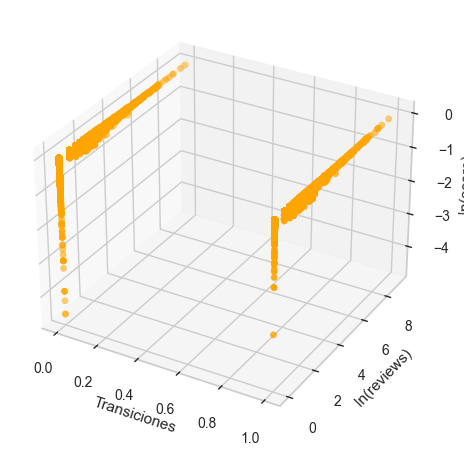

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(logYeo2['has_transitions'], logYeo2['log_review_count'], logYeo2['log_score'], c='orange', marker='o')

# Añadir etiquetas
ax.set_xlabel('Transiciones')
ax.set_ylabel('ln(reviews)')
ax.set_zlabel('ln(score)')

# Mostrar el gráfico
plt.show()

In [51]:
scatterMergedYeo3=mergedYeo[['albumCount','has_transitions','score']]
scatterMergedYeo3['has_transitions']=scatterMergedYeo2['has_transitions'].astype(int)
scatterMergedYeo3

,albumCount,has_transitions,score
0,1.0,1,0.500000
1,1.0,1,0.770000
2,2.0,1,0.860000
3,1.0,1,0.783333
4,3.0,1,0.550000
...,...,...,...
8090,1.0,1,0.700000
8091,1.0,1,0.700000
8092,1.0,0,0.680000
8093,1.0,0,0.680000


# Plot del logaritmo natural del score en función del logaritmo natural del número de albums y el booleano de transiciones

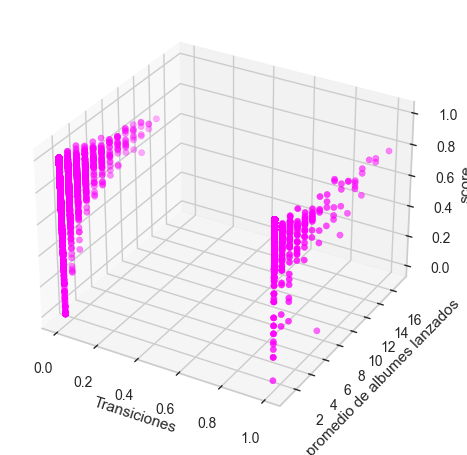

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(scatterMergedYeo3['has_transitions'], scatterMergedYeo3['albumCount'], scatterMergedYeo3['score'], c='magenta', marker='o')

# Añadir etiquetas
ax.set_xlabel('Transiciones')
ax.set_ylabel('promedio de albumes lanzados')
ax.set_zlabel('score')

# Mostrar el gráfico
plt.show()

In [53]:
logYeo3=scatterMergedYeo3.copy()
logYeo3['log_score'] = logYeo3['score'].apply(lambda x: np.log(x))
logYeo3['log_album_count'] = logYeo3['albumCount'].apply(lambda x: np.log(x))
logYeo3

,albumCount,has_transitions,score,log_score,log_album_count
0,1.0,1,0.500000,-0.693147,0.000000
1,1.0,1,0.770000,-0.261365,0.000000
2,2.0,1,0.860000,-0.150823,0.693147
3,1.0,1,0.783333,-0.244197,0.000000
4,3.0,1,0.550000,-0.597837,1.098612
...,...,...,...,...,...
8090,1.0,1,0.700000,-0.356675,0.000000
8091,1.0,1,0.700000,-0.356675,0.000000
8092,1.0,0,0.680000,-0.385662,0.000000
8093,1.0,0,0.680000,-0.385662,0.000000


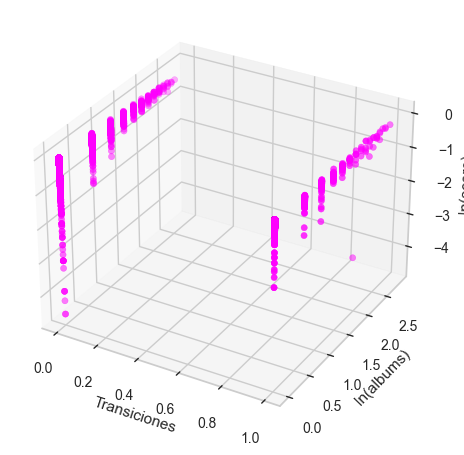

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(logYeo3['has_transitions'], logYeo3['log_album_count'], logYeo3['log_score'], c='magenta', marker='o')

# Añadir etiquetas
ax.set_xlabel('Transiciones')
ax.set_ylabel('ln(albums)')
ax.set_zlabel('ln(score)')

# Mostrar el gráfico
plt.show()

# Regresión lineal de la relación entre $\ln(albumCount)$ y $ln(score)$

In [55]:
XD_withLog = logYeo3[logYeo3['has_transitions'] == 1][['albumCount']]
yD_withLog = logYeo3[logYeo3['has_transitions'] == 1]['score']

XD_withoutLog = logYeo3[logYeo3['has_transitions'] == 0][['albumCount']]
yD_withoutLog = logYeo3[logYeo3['has_transitions'] == 0]['score']

In [56]:
# Dividiendo el conjunto de datos en conjuntos de entrenamiento y prueba
X_trainLog, X_testLog, y_trainLog, y_testLog = train_test_split(XD_withLog, yD_withLog, test_size=0.2, random_state=2)

# Crear el modelo de regresión lineal
lr = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
lr.fit(X_trainLog, y_trainLog)

# Hacer predicciones en el conjunto de prueba
y_predLog = lr.predict(X_testLog)


In [57]:
r2 = r2_score(y_testLog,y_predLog)
print(r2)

0.06932975678124198


# Interpretación de resultados:



<AxesSubplot: xlabel='log_album_count', ylabel='log_score'>

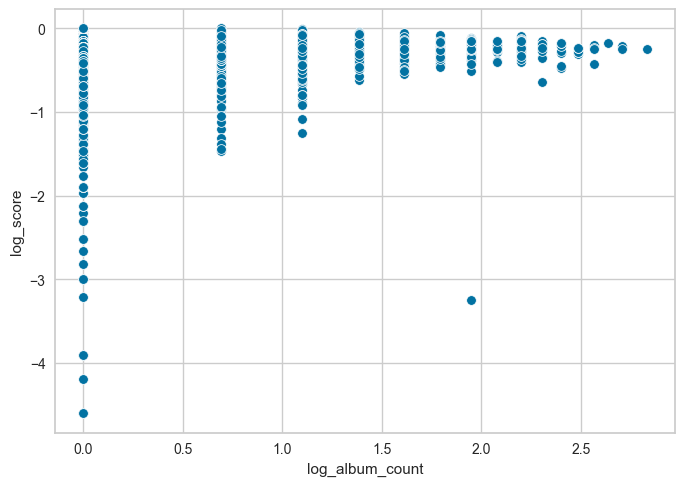

In [58]:
sns.scatterplot(data=logYeo3,x='log_album_count',y='log_score')

<AxesSubplot: xlabel='log_review_count', ylabel='log_score'>

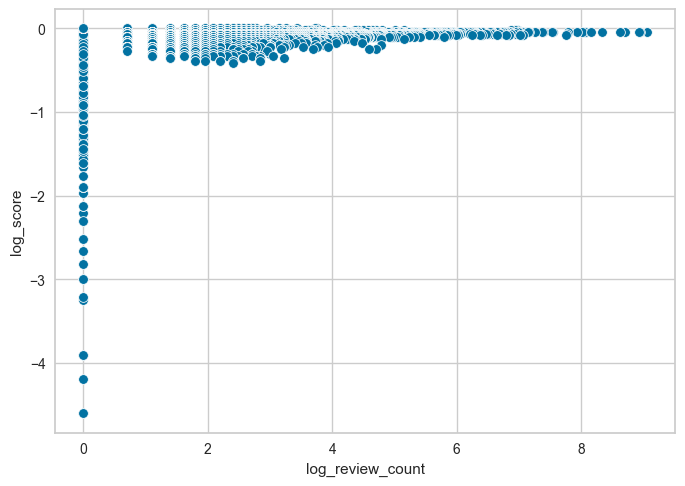

In [59]:
sns.scatterplot(data=logYeo2,x='log_review_count',y='log_score')

<AxesSubplot: xlabel='review_count', ylabel='score'>

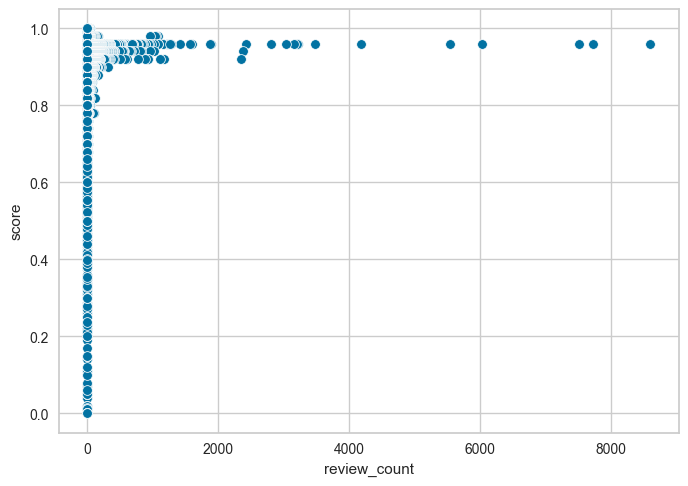

In [60]:
sns.scatterplot(data=scatterMergedYeo2,x='review_count',y='score')

<AxesSubplot: xlabel='albumCount', ylabel='score'>

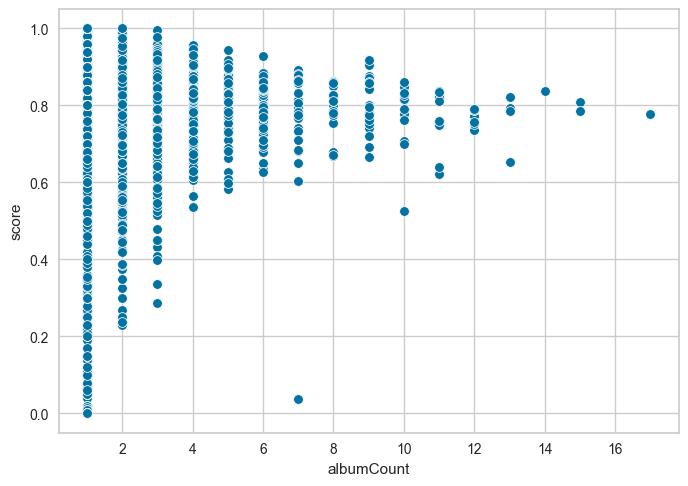

In [61]:
sns.scatterplot(data=scatterMergedYeo3,x='albumCount',y='score')

In [71]:
correlation_merged=mergedYeo.copy()
correlation_merged['has_transitions']=correlation_merged['has_transitions'].astype(int)
correlation_final=correlation_merged[['score','albumCount','review_count']]
correlation_final

,score,albumCount,review_count
0,0.500000,1.0,1
1,0.770000,1.0,1
2,0.860000,2.0,1
3,0.783333,1.0,1
4,0.550000,3.0,1
...,...,...,...
8090,0.700000,1.0,4
8091,0.700000,1.0,4
8092,0.680000,1.0,6
8093,0.680000,1.0,6


In [72]:
correlation = correlation_final.corr(method="pearson")
correlation.head()

,score,albumCount,review_count
score,1.000000,-0.134773,0.085780
albumCount,-0.134773,1.000000,-0.041544
review_count,0.085780,-0.041544,1.000000


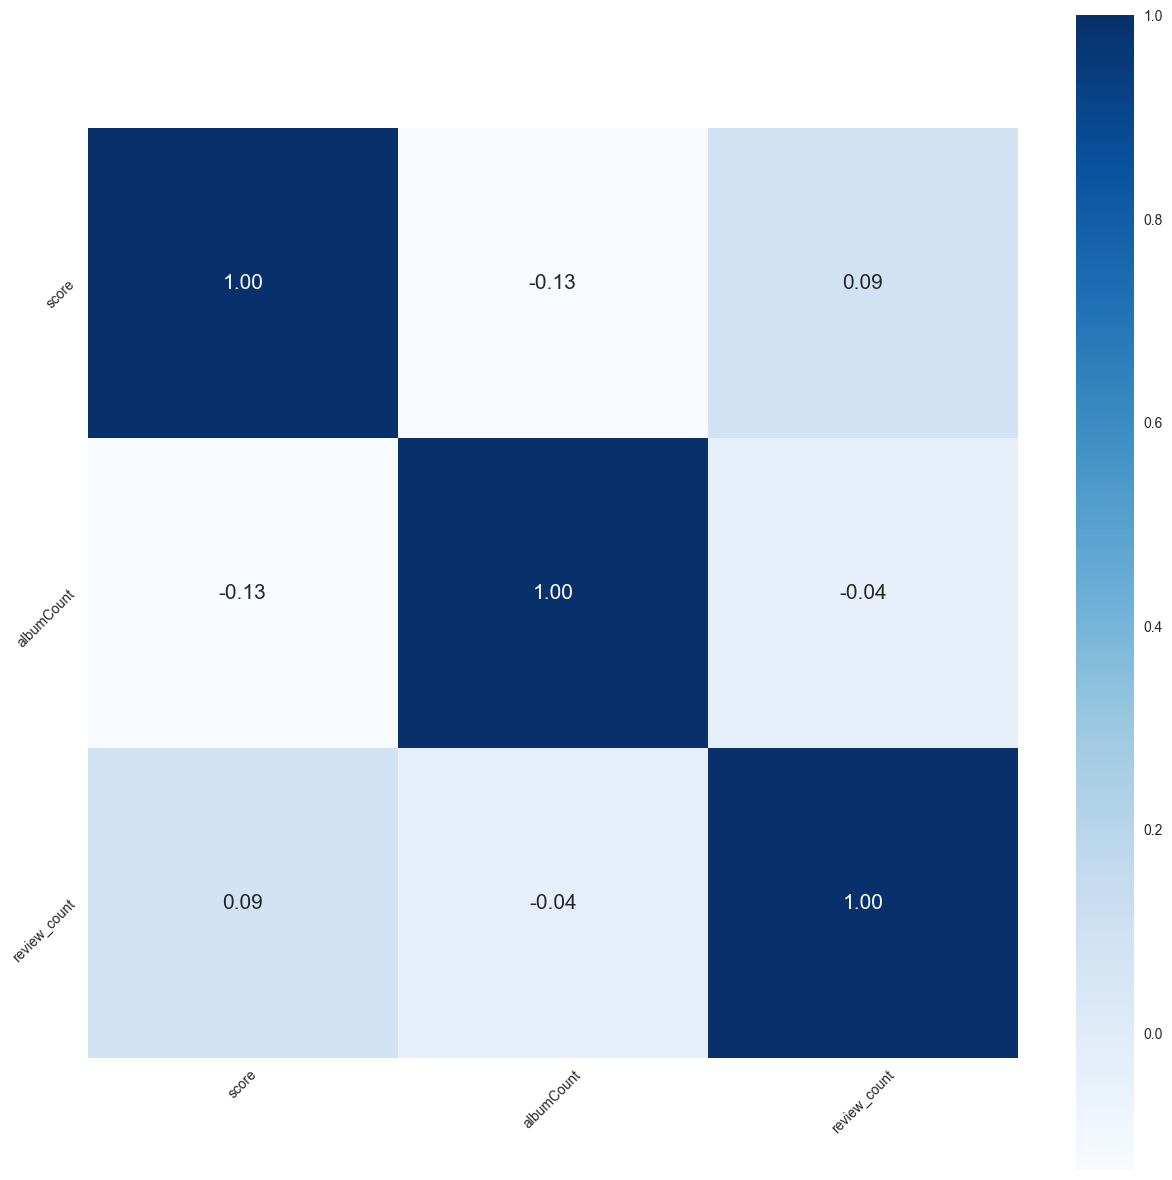

In [78]:
#Resulta más intuitivo ver la matriz de correlación a través de un gráfico - heatmap de seaborn

plt.figure(figsize=(15,15)) #Defino el tamaño del grafico

#Genero el mapa de calor
sns.cubehelix_palette(as_cmap=True)
sns.heatmap(correlation,
            cbar = True,
            square = True,
            annot=True,
            fmt= '.2f',
            annot_kws={'size': 15},
            cmap= "Blues")

#Roto los ejes para que queden inclinados
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.savefig('heat')
plt.show()

In [84]:
X=correlation_final['albumCount']
Y=correlation_final['score']
mi = mutual_info_regression(X.values.reshape(-1, 1), Y.values)
print("Información Mutua:", mi[0])


Información Mutua: 0.20731596713913936


In [86]:
Xx=correlation_final['review_count']
Yy=correlation_final['score']
mii = mutual_info_regression(Xx.values.reshape(-1, 1), Yy.values)
print("Información Mutua:", mii[0])

Información Mutua: 0.028337694671555003


# Transformar los datos con características polinomiales
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(XD)

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_poly, yD)

# Imprimir el valor de R^2
print(f'R^2 score: {model.score(X_poly, yD)}')

# Realizar el scatter plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(deathMeans['has_transitions'], deathMeans['albumCount'], deathMeans['score'], c='r', marker='o')

# Etiquetas para los ejes
ax.set_xlabel('Has Transitions')
ax.set_ylabel('Number of Albums')
ax.set_zlabel('Score')

plt.show()